# Image reconstruction using alternating least squares #

In [1]:
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [2]:
# Read in a image from torchvision
img = torchvision.io.read_image("dog.jpg")
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)

img_scaled = torch.tensor(img_scaled)
img_scaled = img_scaled.to(device)

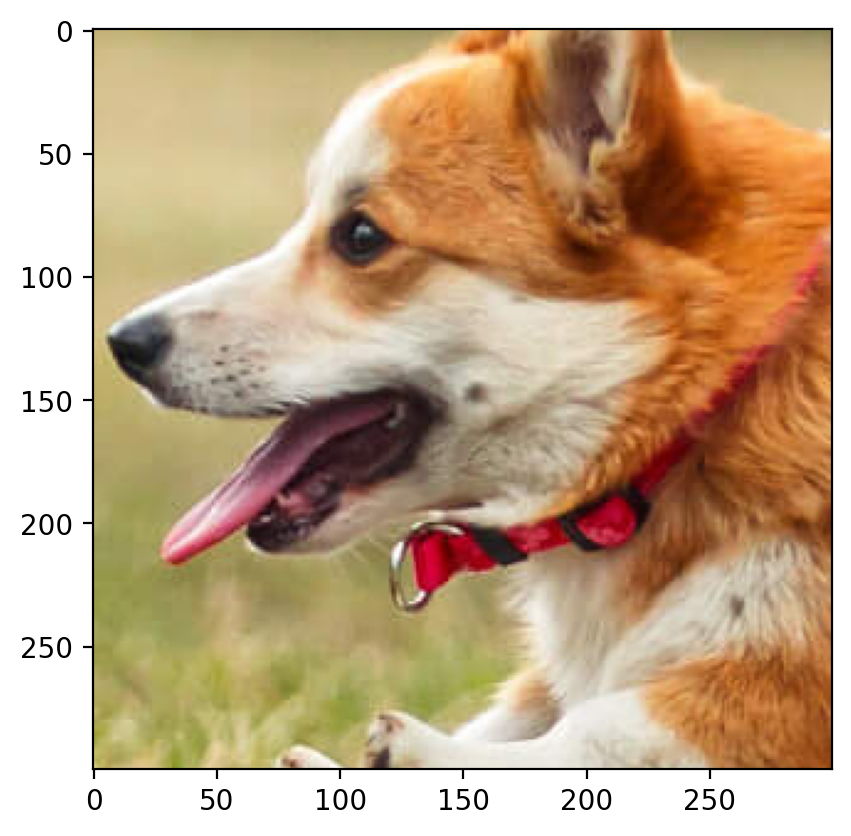

In [3]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 300, 300)
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())
crop = crop.to(device)

### a) a rectangular block of 30X30 is assumed missing from the image. ###

In [4]:
def mask_image(img, start_h, end_h, start_w, end_w):
    img_copy = img.clone().float()  # Convert to float tensor
    mask = torch.zeros_like(img, dtype=torch.bool)
    mask[start_h:end_h, start_w:end_w] = True
    img_copy[mask] = float('nan')
    return img_copy, mask

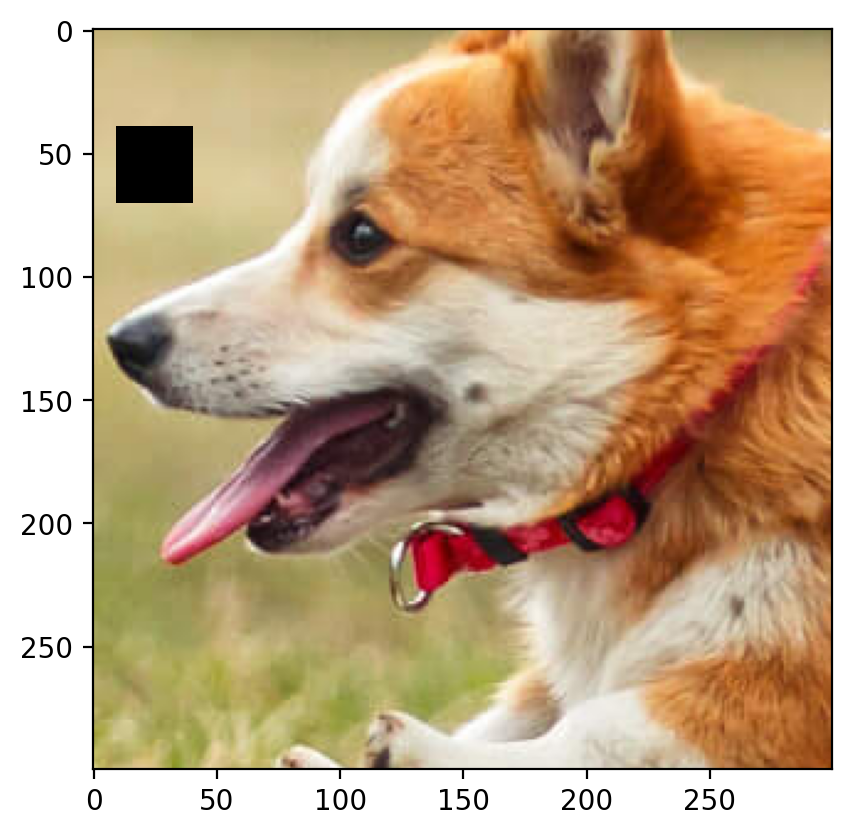

In [5]:
cropR1 = crop[0].clone()
cropG1 = crop[1].clone()
cropB1 = crop[2].clone()

masked_img1 = mask_image(cropR1, 40, 70, 10, 40)
cropR1 = masked_img1[0]
cropG1[masked_img1[1]] = float('nan')
cropB1[masked_img1[1]] = float('nan')

combined_tensor1 = torch.stack((cropR1, cropG1, cropB1), dim=0)
combined_tensor1 = combined_tensor1.detach().float()

plt.imshow(rearrange(combined_tensor1, 'c h w -> h w c').cpu().numpy())

In [6]:
def factorize_als(A, r, max_iter=100, tol=1e-4):
    m, n = A.shape
    W = torch.rand(m, r)
    H = torch.rand(r, n)
    
    mask = ~torch.isnan(A)
    A_masked = torch.where(mask, A, torch.zeros_like(A))
    losses = []
    
    for _ in range(max_iter):
        # Fix W and learn H
        for j in range(n):
            mask_j = mask[:, j]
            W_masked = W[mask_j, :].to(A_masked.dtype)
            H[:, j] = torch.linalg.lstsq(W_masked, A_masked[mask_j, j]).solution.squeeze()
        
        # Fix H and learn W
        for i in range(m):
            mask_i = mask[i, :]
            H_masked = H[:, mask_i].to(A_masked.dtype)
            W[i, :] = torch.linalg.lstsq(H_masked.T, A_masked[i, mask_i]).solution.squeeze()
        
        # Compute the reconstruction error
        loss = torch.norm(A_masked - torch.matmul(W, H))
        losses.append(loss.item())
        if loss < tol:
            break

    return W, H, losses

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


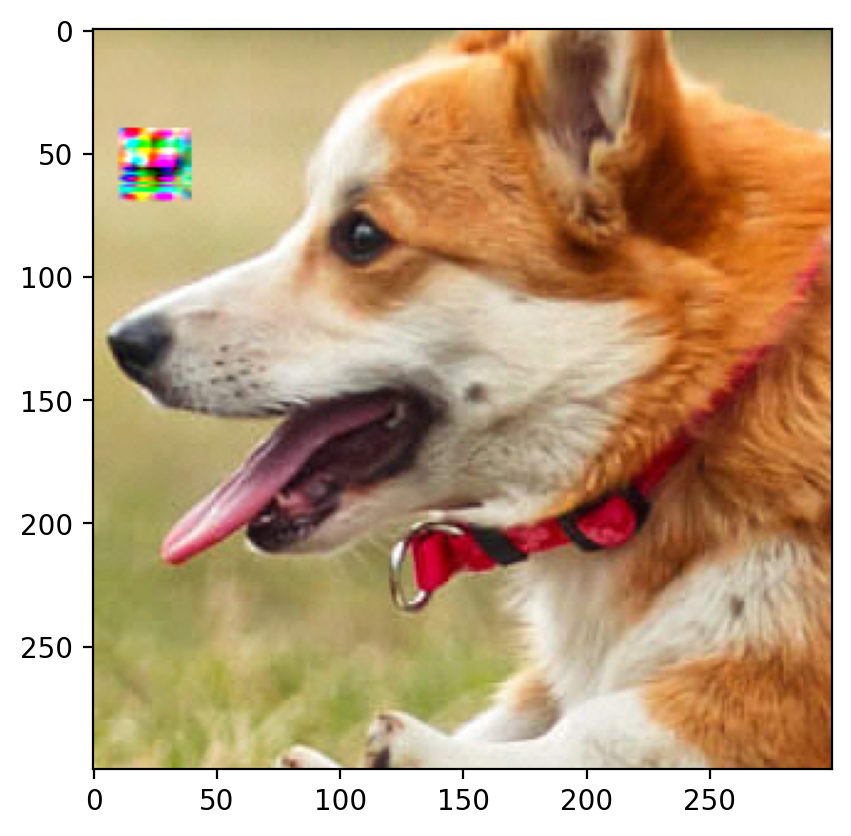

In [7]:
WR1, HR1, loss_R1 = factorize_als(cropR1, r=100, max_iter=100)
WG1, HG1, loss_G1 = factorize_als(cropG1, r=100, max_iter=100)
WB1, HB1, loss_B1 = factorize_als(cropB1, r=100, max_iter=100)

RR1 = torch.mm(WR1,HR1)
GG1 = torch.mm(WG1,HG1)
BB1 = torch.mm(WB1,HB1)
combined_tensor_1 = torch.stack((RR1, GG1, BB1), dim=0)
combined_tensor_1 = combined_tensor_1.detach().float()

plt.imshow(rearrange(combined_tensor_1, 'c h w -> h w c').cpu().numpy())

### b) a random subset of 900 (30X30) pixels is missing from the image. ###

In [8]:
def mask_image_pix(img, num):
    img_copy = img.clone().float()  # Convert to float tensor
    num_pixels = img.numel()  # Total number of pixels in the image
    prop = num/num_pixels
    mask = torch.rand(img.shape) < prop
    img_copy[mask] = float('nan')
    return img_copy, mask

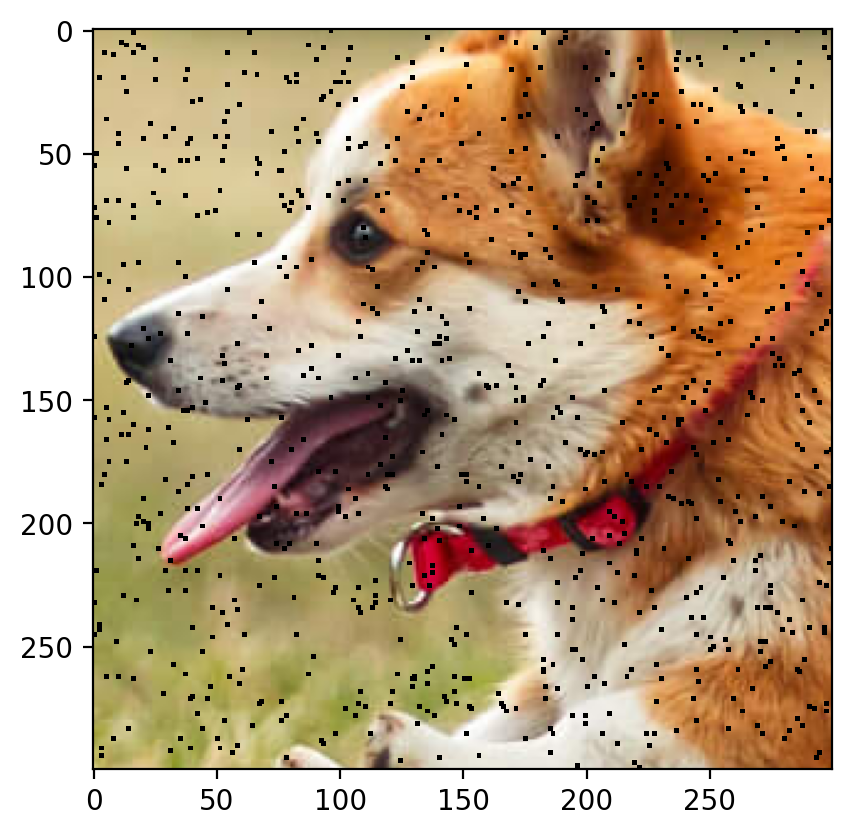

In [9]:
cropR2 = crop[0].clone()
cropG2 = crop[1].clone()
cropB2 = crop[2].clone()

masked_img2 = mask_image_pix(cropR2, 900)
cropR2 = masked_img2[0]
cropG2[masked_img2[1]] = float('nan')
cropB2[masked_img2[1]] = float('nan')

combined_tensor2 = torch.stack((cropR2, cropG2, cropB2), dim=0)
combined_tensor2 = combined_tensor2.detach().float()

plt.imshow(rearrange(combined_tensor2, 'c h w -> h w c').cpu().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


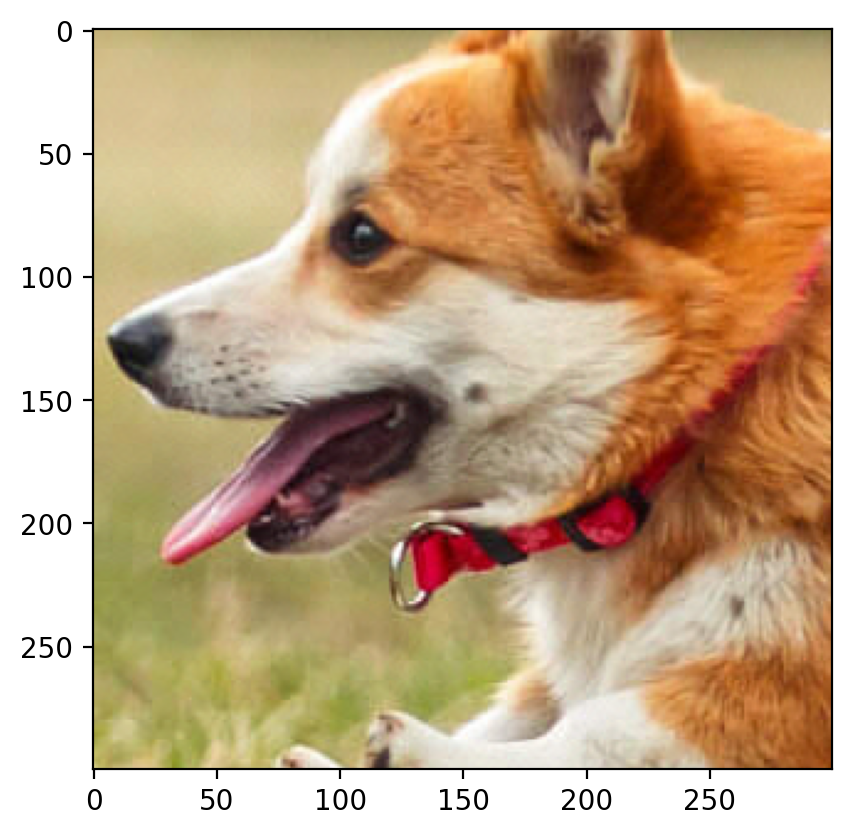

In [10]:
WR2, HR2, loss_R2 = factorize_als(cropR2, r=100, max_iter=100)
WG2, HG2, loss_G2 = factorize_als(cropG2, r=100, max_iter=100)
WB2, HB2, loss_B2 = factorize_als(cropB2, r=100, max_iter=100)

RR2 = torch.mm(WR2,HR2)
GG2 = torch.mm(WG2,HG2)
BB2 = torch.mm(WB2,HB2)
combined_tensor_2 = torch.stack((RR2, GG2, BB2), dim=0)
combined_tensor_2 = combined_tensor_2.detach().float()

plt.imshow(rearrange(combined_tensor_2, 'c h w -> h w c').cpu().numpy())